ASSIGNMENT 2 - Classifying Covid Positive Radiography Images With SVMs and Random Forest Classifiers (After Applying HOG)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip 'drive/MyDrive/Image_Dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Image_Dataset/train/Normal/Normal-864.png  
  inflating: Image_Dataset/train/Normal/Normal-8641.png  
  inflating: Image_Dataset/train/Normal/Normal-8642.png  
  inflating: Image_Dataset/train/Normal/Normal-8643.png  
  inflating: Image_Dataset/train/Normal/Normal-8644.png  
  inflating: Image_Dataset/train/Normal/Normal-8647.png  
  inflating: Image_Dataset/train/Normal/Normal-8650.png  
  inflating: Image_Dataset/train/Normal/Normal-8651.png  
  inflating: Image_Dataset/train/Normal/Normal-8652.png  
  inflating: Image_Dataset/train/Normal/Normal-8655.png  
  inflating: Image_Dataset/train/Normal/Normal-8656.png  
  inflating: Image_Dataset/train/Normal/Normal-8659.png  
  inflating: Image_Dataset/train/Normal/Normal-866.png  
  inflating: Image_Dataset/train/Normal/Normal-8660.png  
  inflating: Image_Dataset/train/Normal/Normal-8661.png  
  inflating: Image_Dataset/train/Normal/Normal-8662.png  
  inflating: Image_Data

In [ ]:
# importing useful libraries
import matplotlib.pyplot as plt     # for plotting
import numpy as np                  # for reshaping, array manipulation
import pandas as pd
import cv2                          # for image loading and colour conversion
import tensorflow as tf             # for bulk image resize
import os
import glob
import random
from skimage.feature import hog
from sklearn.decomposition import PCA
import os
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
import os
import random
from scipy.io import loadmat        # to load mat files
import matplotlib.pyplot as plt     # for plotting
import numpy as np                  # for reshaping, array manipulation
import cv2                          # for colour conversion
import tensorflow as tf    

ONLINE TUTORIAL

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_width = 16
img_height = 32

In [ ]:
# training data

# original - 21715
# trying 70% reduced - 6514

TRAINING_DIRECTORY = 'Image_Dataset/train/'

train_datagen = ImageDataGenerator(rescale =1/255, rotation_range = 0, zoom_range = 0, horizontal_flip = True)
train_generator = train_datagen.flow_from_directory(TRAINING_DIRECTORY, batch_size=6514, class_mode='categorical',target_size = (img_height,img_width), shuffle=True)
                 

Found 10606 images belonging to 3 classes.


In [ ]:
# val data

# original = 5417
# trying out 70% off this data = 1625
VAL_DIRECTORY = 'Image_Dataset/val/'

val_datagen = ImageDataGenerator(rescale =1/255)
val_generator = val_datagen.flow_from_directory(VAL_DIRECTORY, batch_size=1625, class_mode='categorical',target_size = (img_height,img_width),shuffle=True)
                 

Found 3030 images belonging to 3 classes.


In [ ]:
# test data

#original = 6788
#trying out = 2036

TEST_DIRECTORY = 'Image_Dataset/test/'

test_datagen = ImageDataGenerator(rescale =1/255)
test_generator = test_datagen.flow_from_directory(TEST_DIRECTORY, batch_size=2036, class_mode='categorical',target_size = (img_height,img_width),shuffle=False)

Found 1517 images belonging to 3 classes.


In [ ]:
print(train_generator.samples)
print(test_generator.samples)
print(val_generator.samples)

10606
1517
3030


In [ ]:
X_train, Y_train = next(train_generator)
X_test, Y_test = next(test_generator)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(6514, 32, 16, 3)
(1517, 32, 16, 3)
(6514, 3)
(1517, 3)


In [ ]:
train_generator.class_indices

{'COVID': 0, 'Normal': 1, 'Viral Pneumonia': 2}

In [ ]:
# making dimensions 1D for Y label arrays
import pandas as pd

Y_test = pd.DataFrame(Y_test)

for idx, row in Y_test.iterrows():
  if(row[0] == 1.0):
    row[0] = 0

  if(row[1] == 1.0):
    row[0] = 1

  if(row[2] == 1.0):
    row[0] = 2

Y_test = Y_test.iloc[: , :-1]
Y_test = Y_test.iloc[: , :-1]

In [ ]:


# making dimensions 1D for Y label arrays
import pandas as pd

Y_train = pd.DataFrame(Y_train)

for idx, row in Y_train.iterrows():
  if(row[0] == 1.0):
    row[0] = 0

  if(row[1] == 1.0):
    row[0] = 1

  if(row[2] == 1.0):
    row[0] = 2

Y_train = Y_train.iloc[: , :-1]
Y_train = Y_train.iloc[: , :-1]

In [ ]:

Y_test = Y_test.to_numpy().flatten()
Y_train = Y_train.to_numpy().flatten()

In [ ]:
print(Y_test)
print(Y_train)

[0. 0. 0. ... 2. 2. 2.]
[1. 1. 1. ... 1. 1. 2.]


Greyscale and resize


In [ ]:
def resize(images, new_size):
    # tensorflow has an image resize funtion that can do this in bulk
    # note the conversion back to numpy after the resize
    return tf.image.resize(images, new_size).numpy()

def convert_to_grayscale(images):
    # storage for converted images
    gray = []
    # loop through images
    for i in range(len(images)):
        # convert each image using openCV
        gray.append(cv2.cvtColor(np.float32(images[i,:]), cv2.COLOR_RGB2GRAY))
    # pack converted list as an array and return
    return np.expand_dims(np.array(gray), axis = -1)

def plot_images(x, y):
    fig = plt.figure(figsize=[15, 18])
    for i in range(50):
        ax = fig.add_subplot(5, 10, i + 1)
        picture = x[:,:,:,0]
        ax.imshow(picture[i,:], cmap="gray")
        ax.axis('off')


(6514, 32, 16, 1)
(1517, 32, 16, 1)


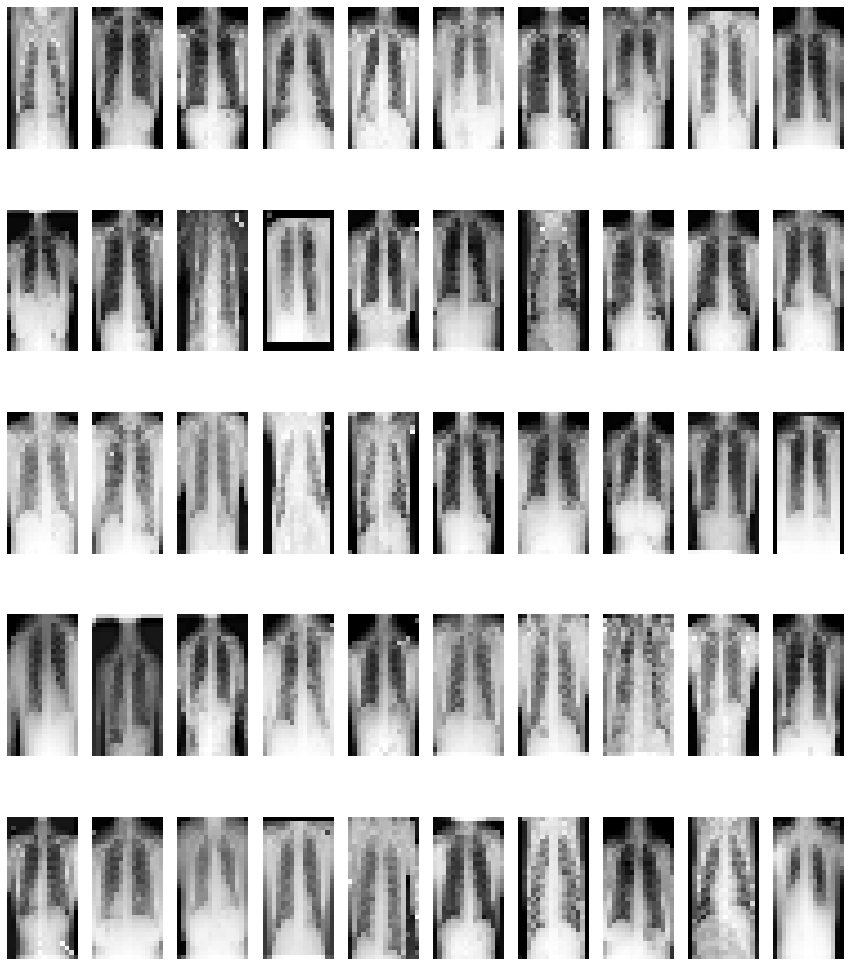

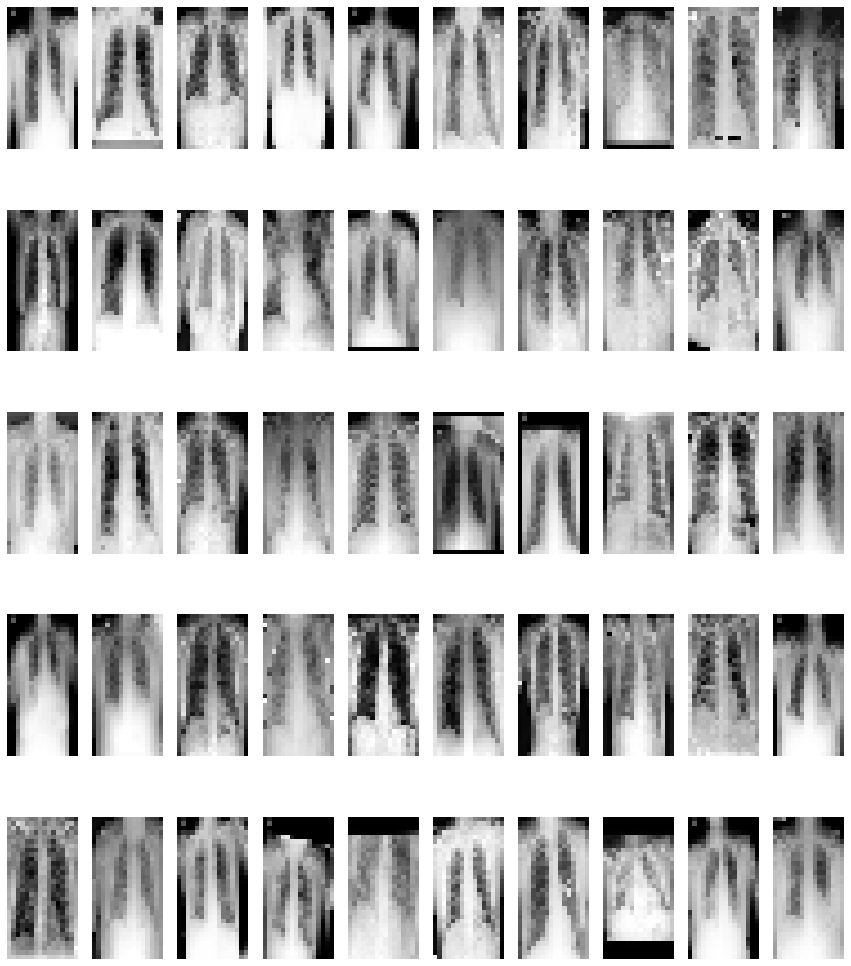

In [ ]:
# conversion and resizing
# resize data and convert to grayscale
train_X_resized_grey = convert_to_grayscale(resize(X_train,(img_height,img_width)))
print(train_X_resized_grey.shape)
test_X_resized_grey = convert_to_grayscale(resize(X_test,(img_height,img_width)))
print(test_X_resized_grey.shape)

# plot some resized and grayscale images (train only)
plot_images(train_X_resized_grey, Y_train)
plot_images(test_X_resized_grey, Y_test)

In [ ]:
# making it 2D instead of 4D

# WITHOUT HOG - preprocessing
train_X_2D = np.array(train_X_resized_grey).reshape(len(train_X_resized_grey),-1)
print(train_X_2D.shape)
test_X_2D = np.array(test_X_resized_grey).reshape(len(test_X_resized_grey),-1)
print(test_X_2D.shape)

(6514, 512)
(1517, 512)


NOW putting it into an SVM

In [ ]:
# function to do our eval for us, this is quite simple and will
# - create a figure
# - draw a confusion matrix for the trainign data in a sub-fig on the left
# - draw a confusion matrix for the testing data in a sub-fig on the right
# - compute the overall classification accuracy on the testing data
# this has simply been created as we're going to do this for each test that we run
#def eval_model(model, X_train, Y_train, X_test, Y_test):
 #   fig = plt.figure(figsize=[25, 8])
  #  ax = fig.add_subplot(1, 2, 1)
  #  conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, xticklabels=['COVID',"Normal","Pneumonia"],yticklabels=['COVID',"Normal","Pneumonia"],  normalize=None, xticks_rotation='vertical', ax=ax)
  #  pred = (model.predict(X_train)).reshape(6514,1)
  #  conf.ax_.set_title('Training Set Performance: ' + str(sum(pred == Y_train)/len(Y_train)));
  #  ax = fig.add_subplot(1, 2, 2)
  #  conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize=None,xticklabels=['COVID',"Normal","Pneumonia"],yticklabels=['COVID',"Normal","Pneumonia"], xticks_rotation='vertical', ax=ax)
  #  pred = (model.predict(X_test)).reshape(1517,1)
  #  conf.ax_.set_title('Testing Set Performance: ' + str(sum(pred == Y_test)/len(Y_test)))

  
import seaborn as sns
from sklearn.metrics import confusion_matrix

def eval_model(model, x_train,y_train, x_test, y_test):
    fig = plt.figure(figsize=[20, 8])
    ax = fig.add_subplot(1, 2, 1)
    pred = model.predict(x_train)
    confusion_mtx = confusion_matrix(y_train, pred)
    sns.heatmap(confusion_mtx, annot=True,fmt='g',xticklabels=['COVID',"Normal","Pneumonia"],yticklabels=['COVID',"Normal","Pneumonia"],ax=ax,cbar=False)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax = fig.add_subplot(1, 2, 2)
    pred = model.predict(x_test)
    prediction = np.array(pred)
    np.save('svmwithouthogprediction.npy', prediction)
    
    pred = model.predict(x_test)
    confusion_mtx = confusion_matrix(y_test, pred)
    sns.heatmap(confusion_mtx, annot=True,fmt='g',xticklabels=['COVID',"Normal","Pneumonia"],yticklabels=['COVID',"Normal","Pneumonia"],ax=ax,cbar=False)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    

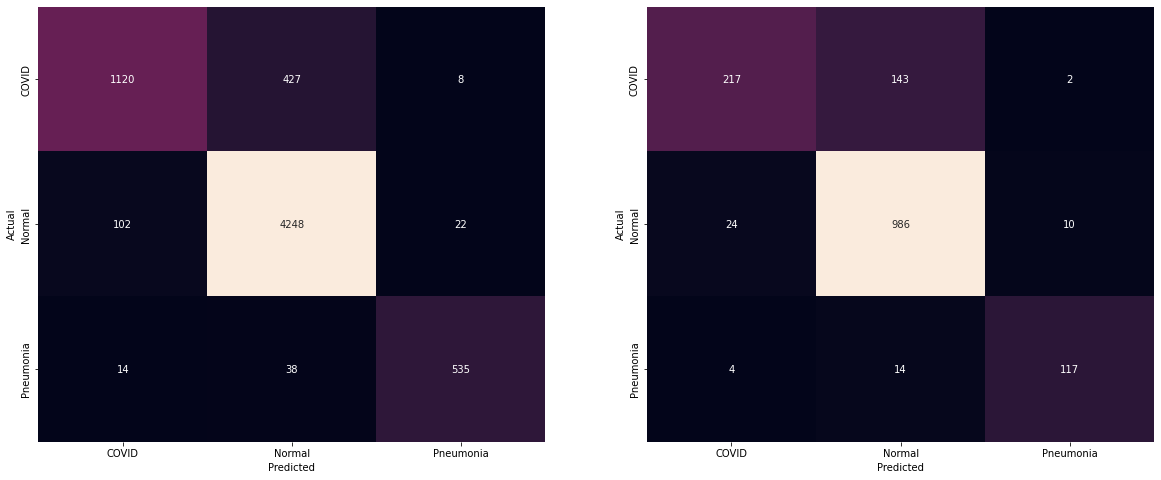

In [ ]:
svm = SVC()
svm.fit(train_X_2D, Y_train)
eval_model(svm, train_X_2D, Y_train, test_X_2D, Y_test)

In [ ]:
print(classification_report(Y_test, svm.predict(test_X_2D)))

              precision    recall  f1-score   support

         0.0       0.89      0.60      0.71       362
         1.0       0.86      0.97      0.91      1020
         2.0       0.91      0.87      0.89       135

    accuracy                           0.87      1517
   macro avg       0.89      0.81      0.84      1517
weighted avg       0.87      0.87      0.86      1517



Trying one vs all!

KeyboardInterrupt: ignored

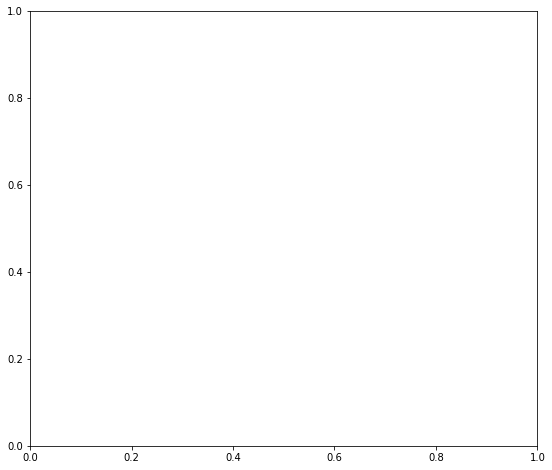

In [ ]:
onevsall_svm = OneVsRestClassifier(SVC(class_weight='balanced'))
onevsall_svm.fit(train_X_2D, Y_train)
eval_model(onevsall_svm, train_X_2D, Y_train, test_X_2D, Y_test)

print(classification_report(Y_test, onevsall_svm.predict(test_X_2D)))

Completing grid search

In [ ]:
param_grid = [
  {'C': [0.1, 1, 10, 100], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100], 'gamma': [0.1, 0.01, 0.001], 'kernel': ['rbf']},
  {'C': [0.1, 1, 10, 100], 'degree': [3, 4, 5], 'kernel': ['poly']},
 ]
svmGrid = SVC(class_weight='balanced')
grid_search = GridSearchCV(svmGrid, param_grid, cv=3)
grid_search.fit(train_X_2D, Y_train)
grid_search.cv_results_

KeyboardInterrupt: ignored

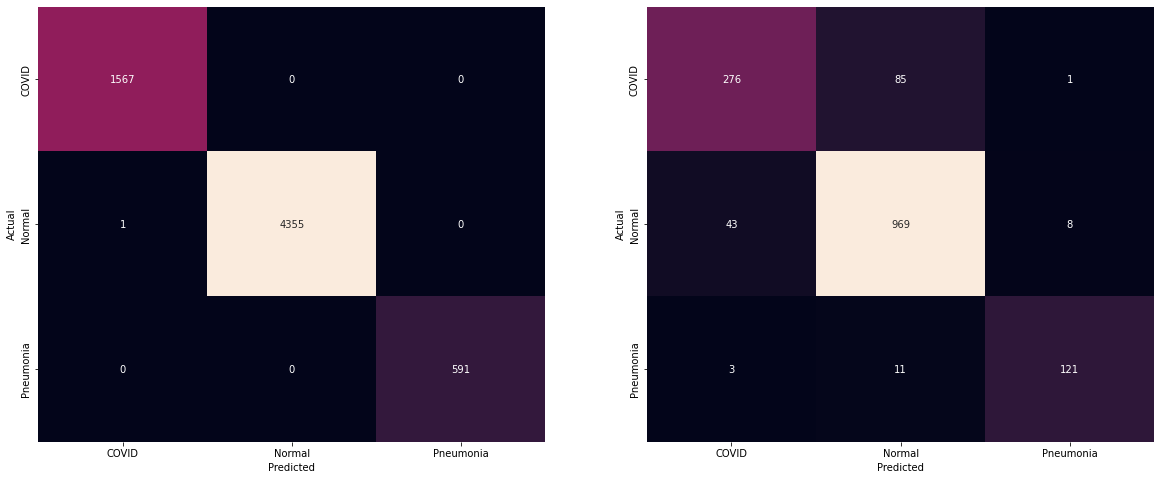

In [ ]:
#best_system = np.argmin(grid_search.cv_results_['rank_test_score'])
#params = grid_search.cv_results_['params'][best_system]
#print(params)
svmFinal = SVC(C=10, gamma=0.1, kernel='rbf',class_weight='balanced')
svmFinal.fit(train_X_2D, Y_train)
eval_model(svmFinal, train_X_2D, Y_train, test_X_2D, Y_test)

In [ ]:
print(classification_report(Y_test, svmFinal.predict(test_X_2D)))

              precision    recall  f1-score   support

         0.0       0.86      0.76      0.81       362
         1.0       0.91      0.95      0.93      1020
         2.0       0.93      0.90      0.91       135

    accuracy                           0.90      1517
   macro avg       0.90      0.87      0.88      1517
weighted avg       0.90      0.90      0.90      1517



HOG

In [ ]:
X_train, Y_train = next(train_generator)
X_test, Y_test = next(test_generator)

print(X_train.shape)
print(X_test.shape)

(4092, 32, 16, 3)
(1517, 32, 16, 3)


In [ ]:
# making dimensions 1D for Y label arrays
import pandas as pd

Y_test = pd.DataFrame(Y_test)

for idx, row in Y_test.iterrows():
  if(row[0] == 1.0):
    row[0] = 0

  if(row[1] == 1.0):
    row[0] = 1

  if(row[2] == 1.0):
    row[0] = 2

Y_test = Y_test.iloc[: , :-1]
Y_test = Y_test.iloc[: , :-1]

# making dimensions 1D for Y label arrays
import pandas as pd

Y_train = pd.DataFrame(Y_train)

for idx, row in Y_train.iterrows():
  if(row[0] == 1.0):
    row[0] = 0

  if(row[1] == 1.0):
    row[0] = 1

  if(row[2] == 1.0):
    row[0] = 2

Y_train = Y_train.iloc[: , :-1]
Y_train = Y_train.iloc[: , :-1]

Y_test = Y_test.to_numpy().flatten()
Y_train = Y_train.to_numpy().flatten()

In [ ]:
def convert_to_grayscale(images):
    # storage for converted images
    gray = []
    # loop through images
    for i in range(len(images)):
        # convert each image using openCV
        gray.append(cv2.cvtColor(np.float32(images[i,:]), cv2.COLOR_RGB2GRAY))
    # pack converted list as an array and return
    return np.expand_dims(np.array(gray), axis = -1)


In [ ]:
def resize(images, new_size):
    # tensorflow has an image resize funtion that can do this in bulk
    # note the conversion back to numpy after the resize
    return tf.image.resize(images, new_size).numpy()

In [ ]:
def plot_images(x, y):
    fig = plt.figure(figsize=[15, 18])
    for i in range(50):
        ax = fig.add_subplot(5, 10, i + 1)
        picture = x[:,:,:,0]
        ax.imshow(picture[i,:], cmap="gray")
        ax.axis('off')

(4092, 32, 16, 1)
(1517, 32, 16, 1)


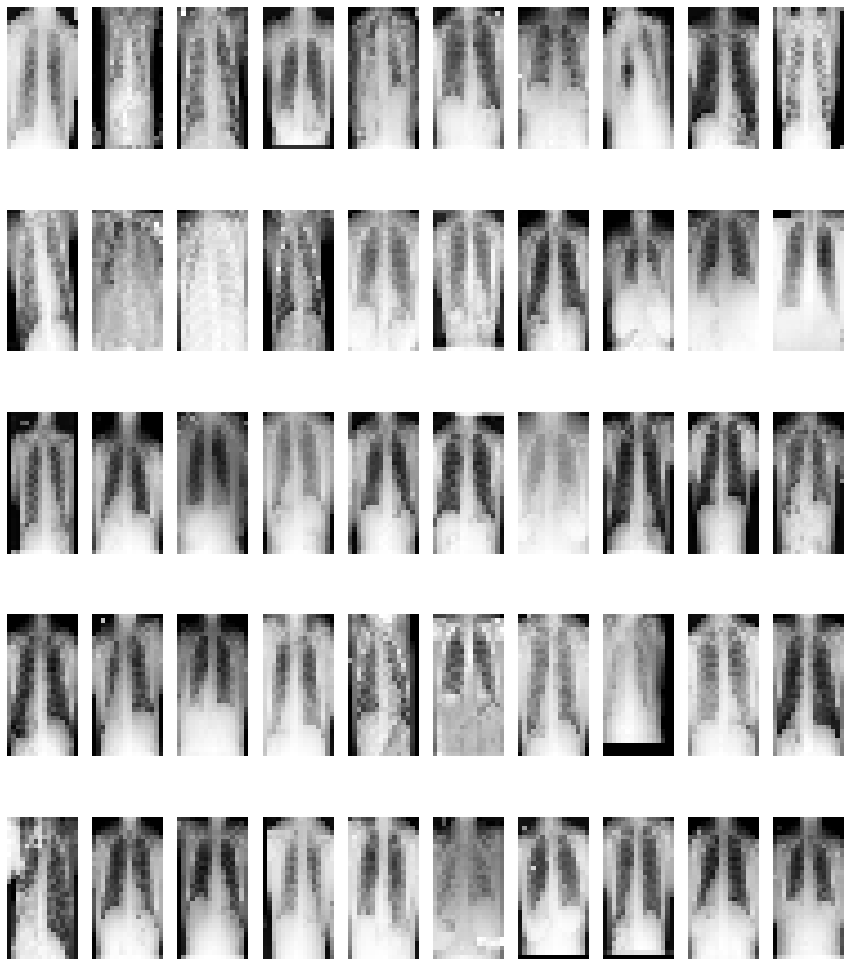

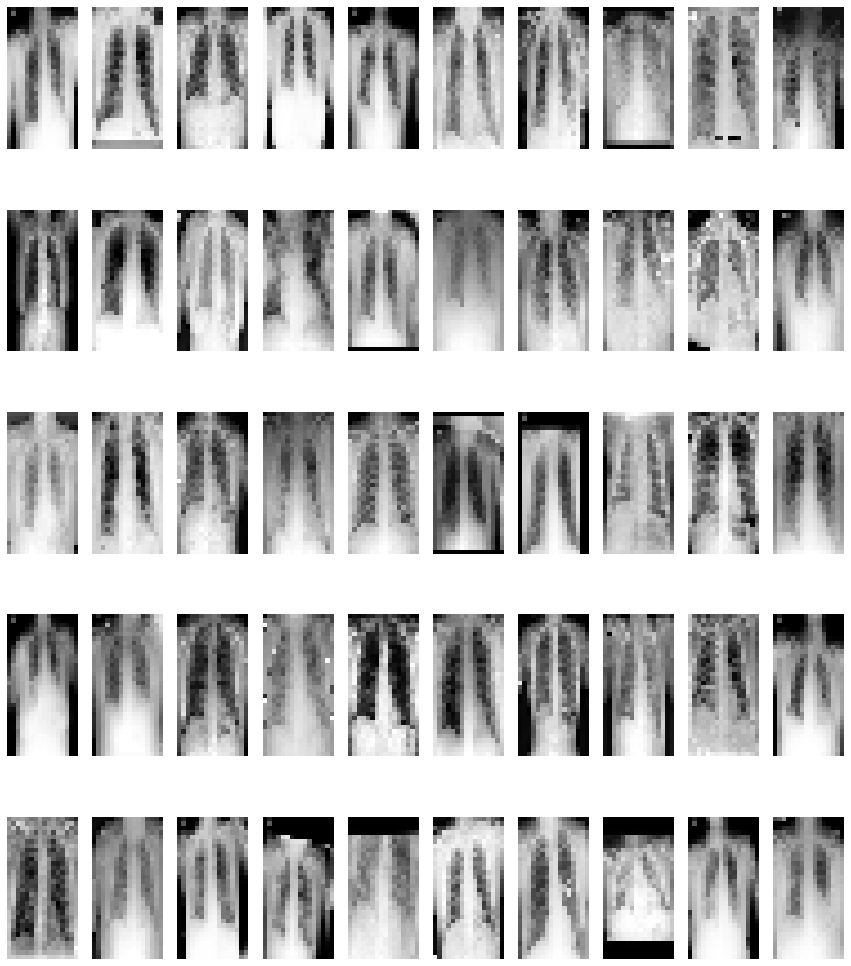

In [ ]:
# conversion and resizing
# resize data and convert to grayscale
train_X_resized_grey = convert_to_grayscale(resize(X_train,(img_height,img_width)))
print(train_X_resized_grey.shape)
test_X_resized_grey = convert_to_grayscale(resize(X_test,(img_height,img_width)))
print(test_X_resized_grey.shape)

# plot some resized and grayscale images (train only)
plot_images(train_X_resized_grey, Y_train)
plot_images(test_X_resized_grey, Y_test)

HOG TIME


In [ ]:
def after_hog_images(images):
    after_hog_imgs = []

    # loop through images
    for i in range(len(images)):
        fd, hog_image = hog(images[i], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=True)
        after_hog_imgs.append(hog_image)

    return after_hog_imgs

In [ ]:
hog_imgs_train = after_hog_images(train_X_resized_grey)
hog_imgs_test = after_hog_images(test_X_resized_grey)

(4092, 32, 16, 1)
(1517, 32, 16, 1)


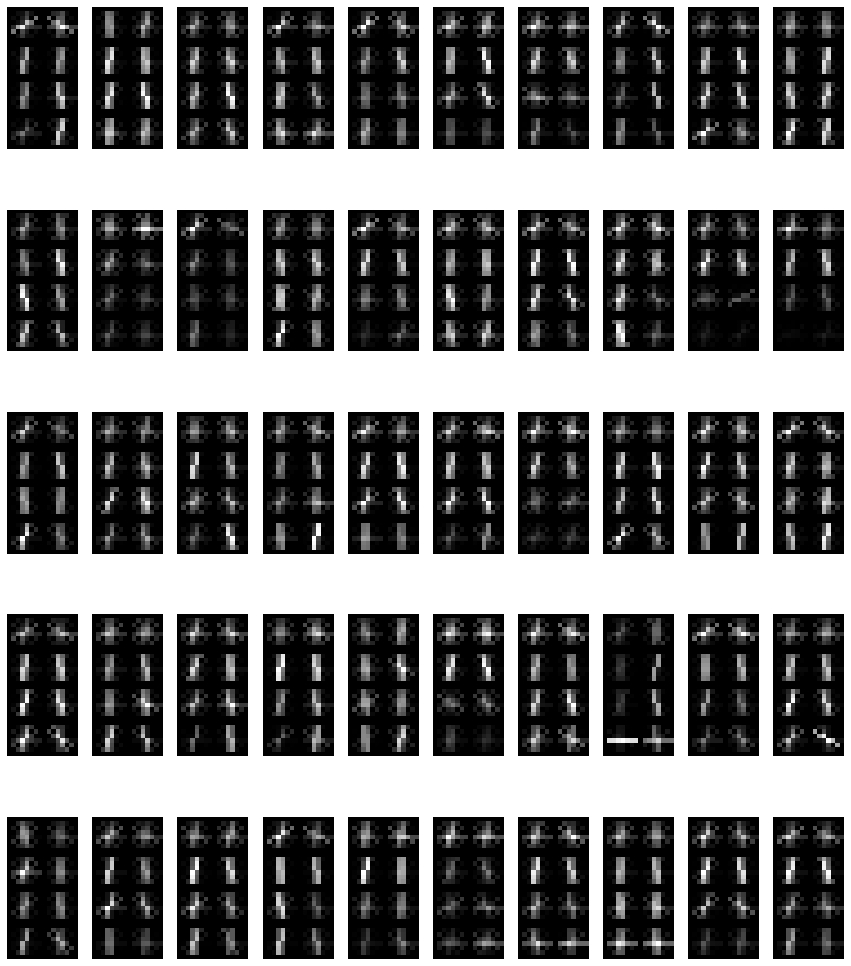

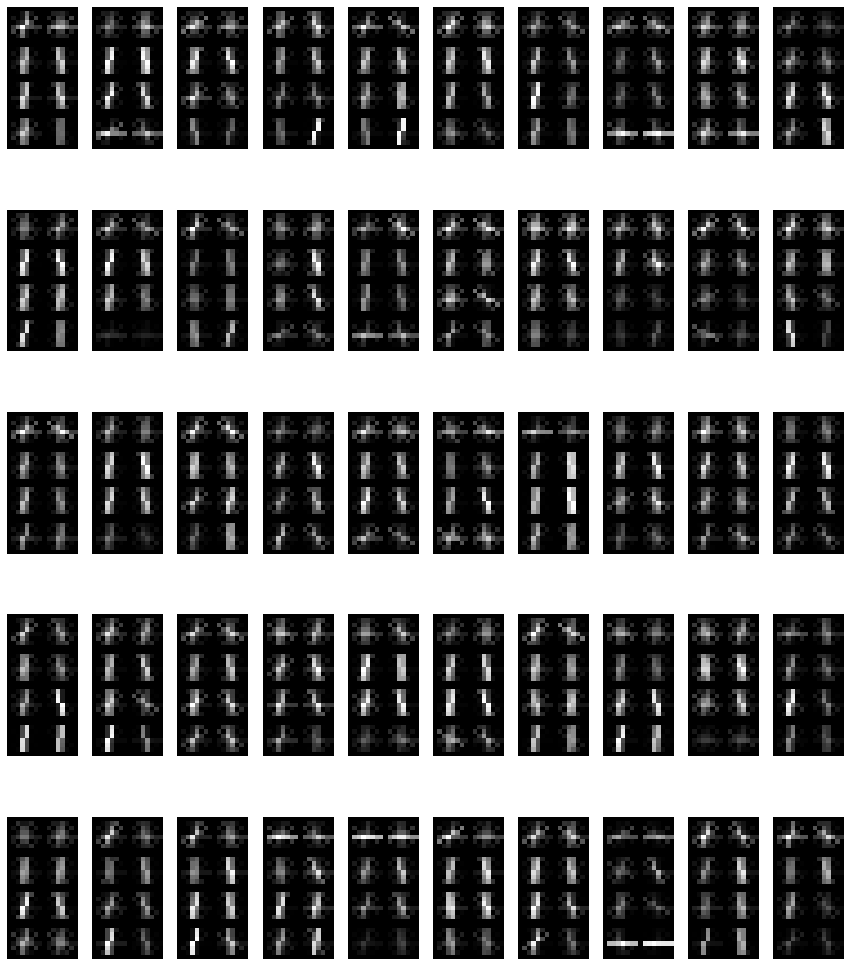

In [ ]:
# plot some resized and grayscale images
hog_imgs_train = np.array(hog_imgs_train)
train_X_expanded_hog_imgs = np.expand_dims(hog_imgs_train, 3)
print(train_X_expanded_hog_imgs.shape)

hog_imgs_test = np.array(hog_imgs_test)
test_X_expanded_hog_imgs = np.expand_dims(hog_imgs_test, 3)
print(test_X_expanded_hog_imgs.shape)

# plot some images
plot_images(train_X_expanded_hog_imgs, Y_train)
plot_images(test_X_expanded_hog_imgs, Y_test)

SVM TIME!

In [ ]:

# function to do our eval for us, this is quite simple and will
# - create a figure
# - draw a confusion matrix for the trainign data in a sub-fig on the left
# - draw a confusion matrix for the testing data in a sub-fig on the right
# - compute the overall classification accuracy on the testing data
# this has simply been created as we're going to do this for each test that we run
#def eval_model(model, X_train, Y_train, X_test, Y_test):
 #   fig = plt.figure(figsize=[25, 8])
  #  ax = fig.add_subplot(1, 2, 1)
   # conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train,xticklabels=['COVID',"Normal","Pneumonia"],yticklabels=['COVID',"Normal","Pneumonia"], normalize=None, xticks_rotation='vertical',)
  #  pred = model.predict(X_train)
  #  conf.ax_.set_title('Training Set Performance: ' + str(sum(pred == Y_train)/len(Y_train)));
  #  ax = fig.add_subplot(1, 2, 2)
  #  conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test,xticklabels=['COVID',"Normal","Pneumonia"],yticklabels=['COVID',"Normal","Pneumonia"], normalize=None, xticks_rotation='vertical',)
  #  pred = model.predict(X_test)
  #  conf.ax_.set_title('Testing Set Performance: ' + str(sum(pred == Y_test)/len(Y_test)));

import seaborn as sns
from sklearn.metrics import confusion_matrix

def eval_model(model, x_train,y_train, x_test, y_test):
    fig = plt.figure(figsize=[20, 8])
    ax = fig.add_subplot(1, 2, 1)
    pred = model.predict(x_train)
    confusion_mtx = confusion_matrix(y_train, pred)
    sns.heatmap(confusion_mtx, annot=True,fmt='g',xticklabels=['COVID',"Normal","Pneumonia"],yticklabels=['COVID',"Normal","Pneumonia"],ax=ax,cbar=False)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax = fig.add_subplot(1, 2, 2)
    pred = model.predict(x_test)
    prediction = np.array(pred)
    np.save('svmhogprediction.npy', prediction)
    
    pred = model.predict(x_test)
    confusion_mtx = confusion_matrix(y_test, pred)
    sns.heatmap(confusion_mtx, annot=True,fmt='g',xticklabels=['COVID',"Normal","Pneumonia"],yticklabels=['COVID',"Normal","Pneumonia"],ax=ax,cbar=False)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

SVM WITH HOG

In [ ]:
# WITH HOG - preprocessing
HOG_train_X_2D = np.array(train_X_expanded_hog_imgs).reshape(len(train_X_expanded_hog_imgs),-1)
print(HOG_train_X_2D.shape)
HOG_test_X_2D = np.array(test_X_expanded_hog_imgs).reshape(len(test_X_expanded_hog_imgs),-1)
print(HOG_test_X_2D.shape)

(4092, 512)
(1517, 512)


ONE VS ONE

              precision    recall  f1-score   support

         0.0       0.71      0.43      0.53       362
         1.0       0.79      0.94      0.86      1020
         2.0       0.84      0.56      0.67       135

    accuracy                           0.78      1517
   macro avg       0.78      0.64      0.69      1517
weighted avg       0.78      0.78      0.76      1517



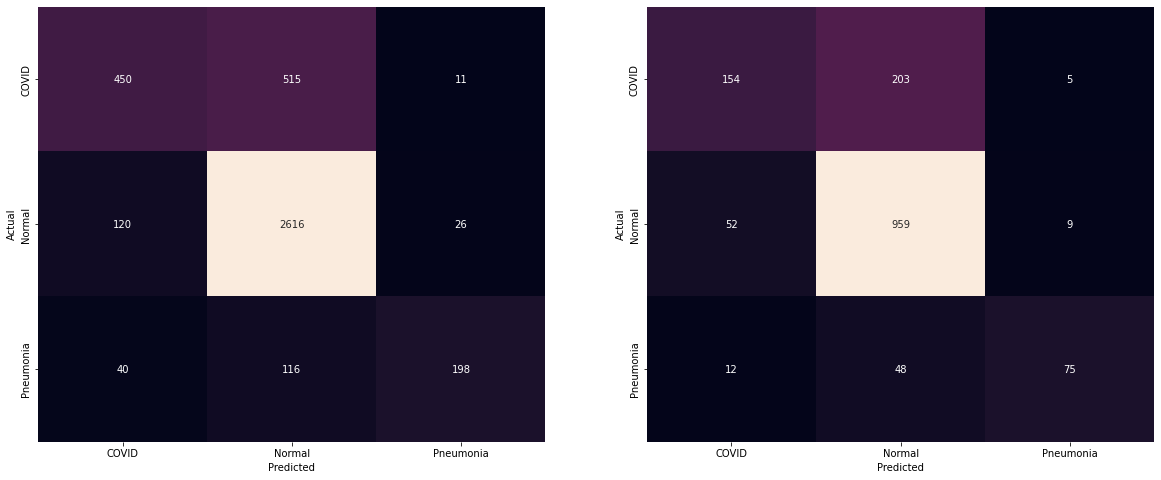

In [ ]:
svmHog1v1 = SVC()
svmHog1v1.fit(HOG_train_X_2D, Y_train)
eval_model(svmHog1v1, HOG_train_X_2D, Y_train, HOG_test_X_2D, Y_test)
print(classification_report(Y_test, svmHog1v1.predict(HOG_test_X_2D)))

ONE VS REST

              precision    recall  f1-score   support

         0.0       0.51      0.80      0.62       362
         1.0       0.91      0.68      0.78      1020
         2.0       0.57      0.84      0.68       135

    accuracy                           0.72      1517
   macro avg       0.67      0.77      0.69      1517
weighted avg       0.79      0.72      0.73      1517



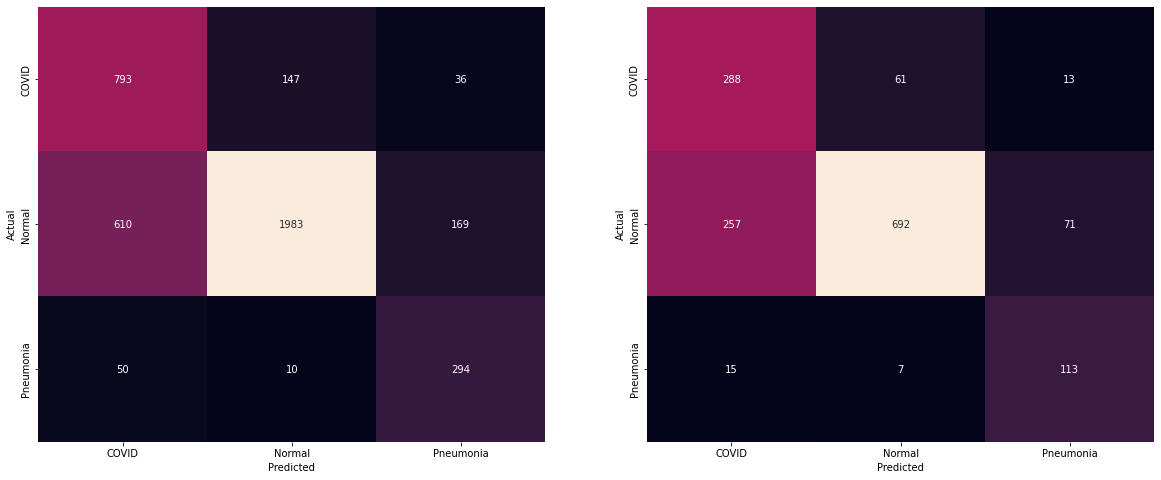

In [ ]:
onevsall_svm_hog = OneVsRestClassifier(SVC(class_weight='balanced'))
onevsall_svm_hog.fit(HOG_train_X_2D, Y_train)
eval_model(onevsall_svm_hog, HOG_train_X_2D, Y_train, HOG_test_X_2D, Y_test)

print(classification_report(Y_test, onevsall_svm_hog.predict(HOG_test_X_2D)))

GRIDSEARCH


In [ ]:
param_grid = [
  {'C': [0.1, 1, 10, 100], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100], 'gamma': [0.1, 0.01, 0.001], 'kernel': ['rbf']},
  {'C': [0.1, 1, 10, 100], 'degree': [3, 4, 5], 'kernel': ['poly']},
 ]
svmGrid = SVC(class_weight='balanced')
grid_search = GridSearchCV(svmGrid, param_grid, cv=3)
grid_search.fit(HOG_train_X_2D, Y_train)

GridSearchCV(cv=3, estimator=SVC(class_weight='balanced'),
             param_grid=[{'C': [0.1, 1, 10, 100], 'kernel': ['linear']},
                         {'C': [0.1, 1, 10, 100], 'gamma': [0.1, 0.01, 0.001],
                          'kernel': ['rbf']},
                         {'C': [0.1, 1, 10, 100], 'degree': [3, 4, 5],
                          'kernel': ['poly']}])

RESULTS

              precision    recall  f1-score   support

         0.0       0.61      0.59      0.60       362
         1.0       0.84      0.86      0.85      1020
         2.0       0.73      0.72      0.72       135

    accuracy                           0.78      1517
   macro avg       0.73      0.72      0.72      1517
weighted avg       0.78      0.78      0.78      1517



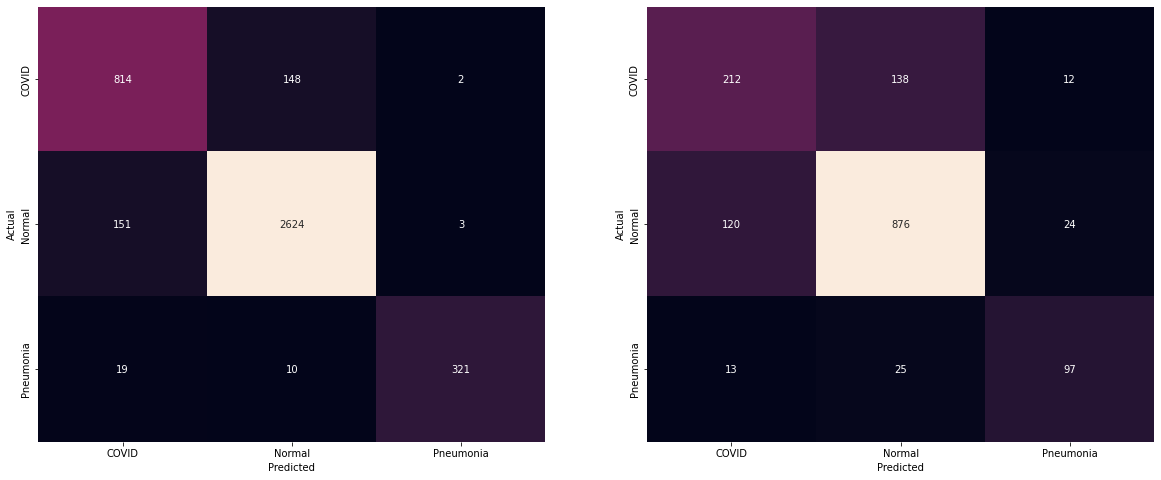

In [ ]:
from time import process_time
#best_system = np.argmin(grid_search.cv_results_['rank_test_score'])
#params = grid_search.cv_results_['params'][best_system]
#print(params)
time_1 = process_time()
svmFinal = SVC(C=100,degree=3,kernel='poly')
svmFinal.fit(HOG_train_X_2D, Y_train)
time_2 = process_time()

eval_model(svmFinal, HOG_train_X_2D, Y_train, HOG_test_X_2D, Y_test)
print(classification_report(Y_test, svmFinal.predict(HOG_test_X_2D)))
time_3 = process_time()

In [ ]:
print('Time to train model:   %f seconds' % (time_2 - time_1))
print('Time to infer model: %f seconds' % (time_3 - time_2))

Time to train model:   4.568074 seconds
Time to infer model: 3.429030 seconds


The end